# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [3]:
# Load pickled data
import pickle
import matplotlib.pyplot as mpplot
%matplotlib inline

training_file = "traffic-signs-data/augmented_train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
### To start off let's do a basic data summary.

#number of training examples
n_train = len(X_train)

#number of testing examples
n_test = len(X_test)

#shape of an image?
image_shape = X_train.shape

#classes in the dataset
n_classes = len(set(y_train))
n_classes_test = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 431299
Number of testing examples = 12630
Image data shape = (431299, 32, 32, 3)
Number of classes = 43


Maximum samples :  24750
Minimum:  2309
Maximum samples :  750
Minimum:  60


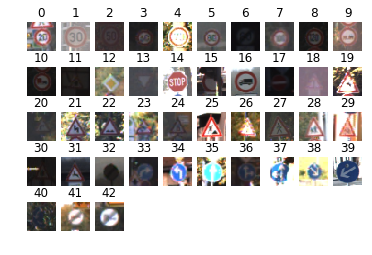

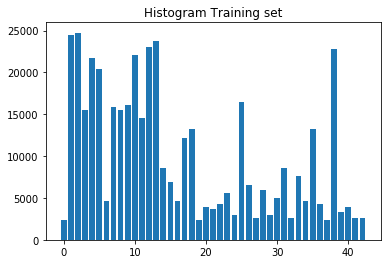

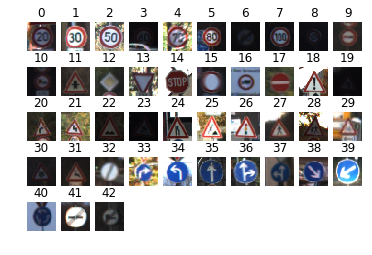

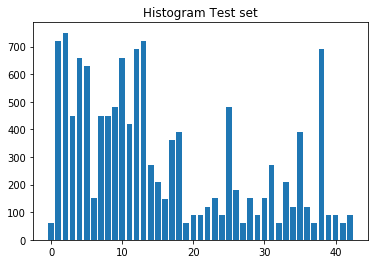

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def show_class_examples(X,y,N,n):
    fig = mpplot.figure()
    done = [0]*n
    for i in range(1,N):
        if done[y[i]] == 0:
            a=fig.add_subplot(5,10,y[i]+1)
            mpplot.imshow(X[i])
            mpplot.axis("off")
            mpplot.title(y[i])
            done[y[i]] = 1
            
def show_class_frequency(y,N,n, type): 
    fig = mpplot.figure()
    done = [0]*n
    x =set()
    for i in range(1,N):
        done[y[i]] += 1
        x.add(y[i])
    a=fig.add_subplot(111)
    mpplot.title("Histogram"+type)
    mpplot.bar(list(x), done)
    print("Maximum samples : ", max(done))
    print("Minimum: ", min(done))
    return done

#training set
show_class_examples(X_train,y_train,n_train, n_classes)
l_train = show_class_frequency(y_train,n_train, n_classes, " Training set")

#test set
show_class_examples(X_test,y_test,n_test, n_classes_test)
l_test = show_class_frequency(y_test,n_test, n_classes_test, " Test set")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
import numpy as np
import cv2

def normalize_input_data(x):
    for i in x:
        i = i.astype('float32')
        i = i/255 -0.5
    
normalize_input_data(X_train)
normalize_input_data(X_test)

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)



def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img


def augment_training_data(X_train, y_train, n_train):
    for i in range(n_train):
        if i%10 == 0: 
            print(i)
        for j in range(10):
            X_train = np.append(X_train, [transform_image(X_train[i], 20, 10, 10)], axis=0)
            y_train = np.append(y_train, [y_train[i]], axis=0)
    print(len(X_train), len(y_train))

    augmented_train={}
    augmented_train['features'] = X_train
    augmented_train['labels'] = y_train
    pickle.dump(augmented_train, "traffic-signs-data/augmented_train.b")

print(X_train.shape)
#augment_training_data(X_train, y_train, n_train)
                

(431299, 32, 32, 3)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Normalize the input data
_We need to normalize the input to zero mean ranging between -0.5 to 0.5. This will remove any skews during cost function optimization allowing the gradient descent algorithm to converge easily._

### Augment the data to improve learning.
_In the real world we will not be looking at traffic signs head on. We will be looking at the signs from various angles. We try to simulate the real world viewing angles and scales by introducing rotational, traslational and searing distortion to the image. This allows the learning to be more robust to such distortions. As a side-effect we also obtain a larger data-set allowing the training to be more thorough._<br>
_I perform the augmentation seperatily in a file called_ augment\_data.py _since it takes a large amount of time to generate the data._

Number of training examples = 288970
Number of validation examples = 142329
Number of testing examples = 12630
Image data shape = (288970, 32, 32, 3)
Number of classes = 43
Maximum samples :  16672
Minimum:  1517
Maximum samples :  8083
Minimum:  729
Maximum samples :  750
Minimum:  60


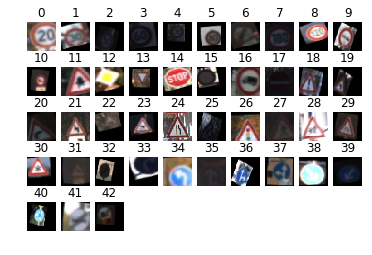

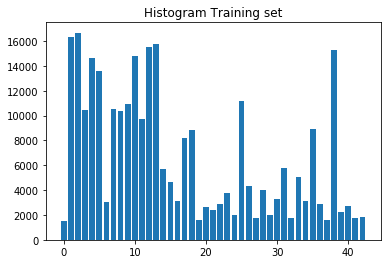

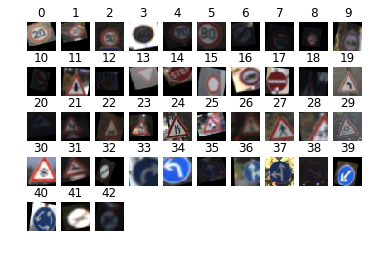

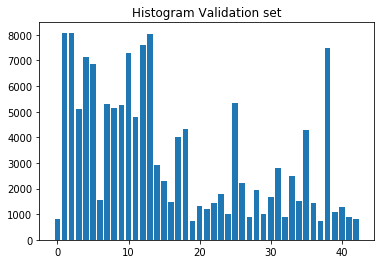

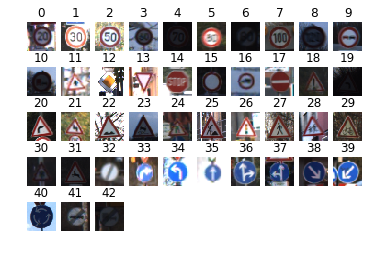

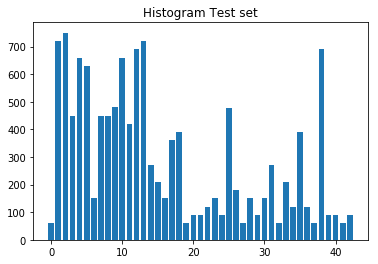

In [7]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

#number of training examples
n_train = len(X_train)

#number of validation examples
n_validation = len(X_validation)

#number of testing examples
n_test = len(X_test)

#shape of an image?
image_shape = X_train.shape

#classes in the dataset
n_classes = len(set(y_train))
n_classes_validation = len(set(y_validation))
n_classes_test = len(set(y_test))


assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

#training set
show_class_examples(X_train,y_train,n_train, n_classes)
l_train = show_class_frequency(y_train,n_train, n_classes, " Training set")

#validation set
show_class_examples(X_validation,y_validation,n_validation, n_classes_validation)
l_validation = show_class_frequency(y_validation,n_validation, n_classes_validation, " Validation set")

#test set
show_class_examples(X_test,y_test,n_test, n_classes_test)
l_test = show_class_frequency(y_test,n_test, n_classes_test, " Test set")





### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
_I divided the augmented and normalized training set into 66% training and 33% validation set. The augmented training set is 10 times the original training set and has number of rotional, shearing and translation distortions. This allows the learning to be more robust to such distortions. As a side-effect we also obtain a larger data-set allowing the training to be more thorough._

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [9]:
### Define your architecture here.

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits



    

In [10]:
def VggNet(x, keep_prob):
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)
    print("befor pooling conv1", conv1)

    # Pooling. Input = 30x30x16. Output = 15x15x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    print("conv1", conv1)
    # Layer 2: Convolutional. Output = 15x15x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 15x15x32. Output = 6x6x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("conv2", conv2)
    # Layer 3: Convolutional. Output = 6x6x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Pooling. Input = 6x6x64. Output = 2x2x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("conv3", conv3)

    # Layer 4: Convolutional. Output = 2x2x128.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 64, 128), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(128))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b

    # Activation.
    conv4 = tf.nn.relu(conv4)

    print("conv4", conv4)


    # Flatten. Input = 2x2x128. Output = 512
    fc0   = flatten(conv4)
    print(fc0)

    # Layer 5: Fully Connected. Input = 512. Output = 256.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(256))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 6: Fully Connected. Input = 256. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 7: Fully Connected. Input = 128. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

_I tried both LeNet architecture described in the course as well as modified VggNet like architecture that increases in depth with the number of CNN layers. I found that the modified Vggnet performed slightly better than LeNet(with dropout on hidden fc layer) and decided to stick with that archtecture. The modified Vggnet consists of 7 layers: 4 CNN followed by 3 fully connected layers. I added a dropout between layer 5 and 6 to reduce overfitting the data._

Using the NON-AUGMENTED dataset:<br>
15 epochs: Lenet 94% validation accuracy with 88% prediction accuracy<br>
15 epochs: Vggnet 98% validation accuracy with 94% prediction accuracy<br>


### _Modified VggNet consists of:_
   _Layer 1: Convolutional 3X3 filter with VALID padding. Input = 32x32x3. Output = 30x30x16._<br>
   _RELU Activation._<br>
   _Pooling. Input = 30x30x16. Output = 15x15x16._<br>
   _Layer 2: Convolutional 3X3 filter with VALID padding. Input = 15x15x16. Output = 15x15x32._<br>
   _RELU Activation._<br>
   _Pooling. Input = 15x15x32. Output = 6x6x32._<br>
   _Layer 3: Convolutional 3X3 filter with VALID padding. Output = 6x6x64._<br>
   _RELU Activation._<br>
   _Pooling. Input = 6x6x64. Output = 2x2x64._<br>
   _Layer 4: Convolutional 1X1 filter with VALID padding. Output = 2x2x128._<br>
   _RELU Activation._<br>
   _Flatten. Input = 2x2x128. Output = 512._<br>
   _Layer 5: Fully Connected. Input = 512. Output = 256._<br>
   _RELU Activation._<br>
   _DROPOUT aded with probability of 0.75_<br>
   _Layer 6: Fully Connected. Input = 256. Output = 128._<br>
   _RELU Activation._<br>
   _Layer 7: Fully Connected. Input = 128. Output = 43._<br>
   _RELU Activation._<br>


In [11]:
### Train your model here.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Hyperparameters
EPOCHS = 30
BATCH_SIZE = 128
rate = 0.001
KEEP_PROB = 0.5

logits = VggNet(x, keep_prob)
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


befor pooling conv1 Tensor("Relu:0", shape=(?, 30, 30, 16), dtype=float32)
conv1 Tensor("MaxPool:0", shape=(?, 15, 15, 16), dtype=float32)
conv2 Tensor("MaxPool_1:0", shape=(?, 6, 6, 32), dtype=float32)
conv3 Tensor("MaxPool_2:0", shape=(?, 2, 2, 64), dtype=float32)
conv4 Tensor("Relu_3:0", shape=(?, 2, 2, 128), dtype=float32)
Tensor("Flatten/Reshape:0", shape=(?, 512), dtype=float32)


In [14]:


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, save_path="vggnet.ckpt")
    print("Model saved")

    
    


Training...

EPOCH 1 ...
Validation Accuracy = 0.858

EPOCH 2 ...
Validation Accuracy = 0.898

EPOCH 3 ...
Validation Accuracy = 0.942

EPOCH 4 ...
Validation Accuracy = 0.942

EPOCH 5 ...
Validation Accuracy = 0.957

EPOCH 6 ...
Validation Accuracy = 0.957

EPOCH 7 ...
Validation Accuracy = 0.959

EPOCH 8 ...
Validation Accuracy = 0.961

EPOCH 9 ...
Validation Accuracy = 0.954

EPOCH 10 ...
Validation Accuracy = 0.965

EPOCH 11 ...
Validation Accuracy = 0.960

EPOCH 12 ...
Validation Accuracy = 0.958

EPOCH 13 ...
Validation Accuracy = 0.964

EPOCH 14 ...
Validation Accuracy = 0.963

EPOCH 15 ...
Validation Accuracy = 0.967

EPOCH 16 ...
Validation Accuracy = 0.969

EPOCH 17 ...
Validation Accuracy = 0.959

EPOCH 18 ...
Validation Accuracy = 0.961

EPOCH 19 ...
Validation Accuracy = 0.958

EPOCH 20 ...
Validation Accuracy = 0.968

EPOCH 21 ...
Validation Accuracy = 0.960

EPOCH 22 ...
Validation Accuracy = 0.970

EPOCH 23 ...
Validation Accuracy = 0.968

EPOCH 24 ...
Validation Accura

In [15]:

with tf.Session() as sess:
    print("Running tests...")
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Running tests...
Test Accuracy = 0.961


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_<br>




**Answer:**<br>

Using the NON-AUGMENTED taining data: 

EPOCHS = 15 <br>
BATCH_SIZE = 128<br>
LEARNING_RATE = 0.01<br>
OPTIMIZER = AdamOptimizer<br>
KEEP_PROBABILITY for dropouts = 0.5<br>

After each epoch, I would test against the validation data. The validation accuracy of increased from 70% to 98.5% for vggnet. The test accuracy was 93%.
For LeNet validation accuracy increased from 40% to 94% and test accuracy was 89%.
The ~4% loss in accuracy was due to overfitting the training data. 

Using AUGMENTED training data:

EPOCHS = 30 <br>
BATCH_SIZE = 128<br>
LEARNING_RATE = 0.01<br>
OPTIMIZER = AdamOptimizer<br>
KEEP_PROBABILITY for dropouts = 0.5<br>

The validation accuracy and test accuracy was about 96%. I stopped at 30 epochs since the training accuracy seemed to have converged at that point.
Since we have used a lot more data to train the model, the model now has knowledge of a larger variation of the data. Therefore we see a slight improvement in both validation and test accuracy. But the test accuracy is now close to the validation accuracy because we have gotten rid of the overfitting error. 


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First I was conservative and made sure that I was able to get a good result using LeNet. Then I read up on various architectures and decided to use VggNet since it was a simple architecture that made sense to me. Finally I reduced overfitting using dropouts.

The Modified VggNet took fewer epochs to train the same data but had more layers and neurons. 

This was all performed on training data provided for the course. After the initial result, I augmented the data to create more training samples. Generating the augmented data took over 2 days. I trained using augmented data on AWS.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

[22 33 17 28 13 17 33 22 28 14]
[25 26  3 ..., 42 12 39]


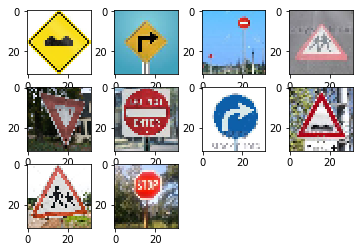

In [68]:
import os

X_new_test_data=np.empty([0, 32, 32, 3])
y_new_test_data=np.zeros(10, dtype='int32')
namenewdata=[]
fig = mpplot.figure()
i=0

for file in os.listdir("traffic-signs-data/new_test_data"):
    if file.split(".")[-1] == "jpg":
        i +=1
        image = mpplot.imread("traffic-signs-data/new_test_data/"+file)
        resized = cv2.resize(image, (32, 32))
        if resized.shape[2]==4:
            resized = np.delete(resized,3,2)
        fig.add_subplot(3,4,i)
        mpplot.imshow(resized)
        val = np.zeros((43))
        val[int(file.split(".")[0].split("_")[-1])] = 1
        X_new_test_data = np.append(X_new_test_data, [resized], axis=0)
        y_new_test_data[i-1] = int(file.split(".")[0].split("_")[-1])
        namenewdata.append(file.split(".")[0].split("_")[0])
print(y_new_test_data)
print(y_test)
                          

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [107]:
### Run the predictions here.
with tf.Session() as sess:
    print("Running predictions for new test data...")
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_new_test_data, y: y_new_test_data, keep_prob: 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    output =  sess.run(softmax, feed_dict={x: X_new_test_data, y: y_new_test_data, keep_prob: 1.0})
    top5 = tf.nn.top_k(output, 5)
    top5_pred = sess.run(top5, feed_dict={x: X_new_test_data, y: y_new_test_data, keep_prob: 1.0})

print(top5_pred[1][0])

Running predictions for new test data...
Test Accuracy = 0.700
[12 29 11 25 26]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**
It seems like we got 70% accuracy on the new test data. Not as well on the original data set but pretty decent for signs that may be similar but vary in shape or color, since the original data is from the german data set.

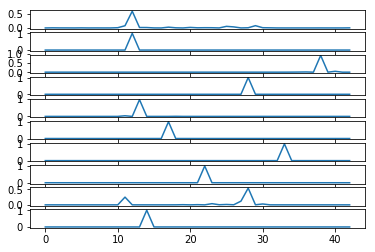

In [70]:
### Visualize the softmax probabilities here.
fig = mpplot.figure()
for i in range(10):
    fig.add_subplot(10,1,i+1)
    mpplot.plot(output[i])


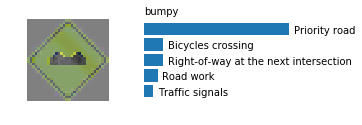

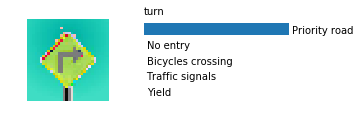

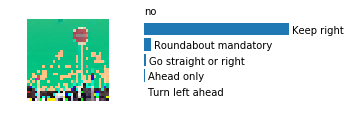

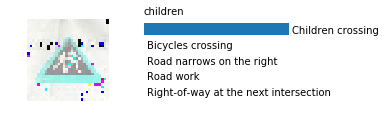

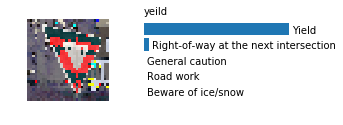

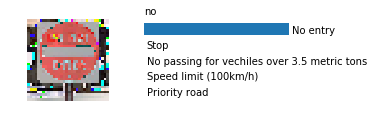

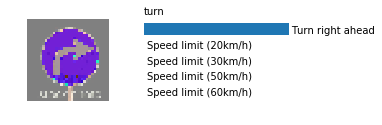

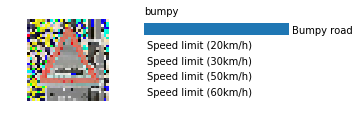

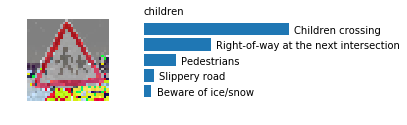

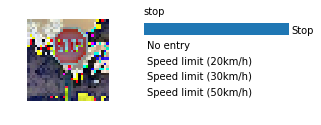

In [117]:
signnames=[]
import csv
import matplotlib.gridspec as gridspec
with open("signnames.csv", 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            signnames.append(row[1])

for i in range(10):
    mpplot.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
    mpplot.subplot(gs[0])
    mpplot.imshow(X_new_test_data[i]+0.5)
    mpplot.axis('off')
    mpplot.subplot(gs[1])
    mpplot.barh(6-np.arange(5),top5_pred[0][i], align='center')
    for i_label in range(5):
        mpplot.text(top5_pred[0][i][i_label]+.02,6-i_label-.25,
            signnames[top5_pred[1][i][i_label]+1])
    mpplot.axis('off');
    mpplot.text(0,6.95,namenewdata[i].split('.')[0]);
    mpplot.show();

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


 Much of the time the data were NOT in the top 5 probabilities.
  
  To be fair some of the traffic signs were of a different color and symbol because they are american signs. I am confident that the model would perform better on a dataset that consists only of German signs.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.